# 線形回帰： Linear_Regression
　今回は, 例として簡単な線形回帰モデルを作成する. ライブラリはscikit-learnを使用.  
 公式ドキュメント：https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html  
 
 EDAの結果をもとに, 下記の特徴量を使用する
 - J1とJ2で違いがあったので, J1フラグ
 - 12月の試合の観客動員数が突出していたので, 12月フラグ
 - ホームチームごとに観客動員数は差があるので, ホームチーム時の平均観客動員数(**この変数はリークあり**)
   - yの平均と, 情報は圧縮していますが, 学習データの説明変数に目的変数の情報が入っています
   - ターゲットエンコーディングなどで回避するとリークを含まない丁寧なモデル作成となります
   - サンプルでは簡易的に済ませたいので, 学習データ全体でホームチームごとにyの平均をとったものを使用します
 - 傾向のあったTV放送数, NHKフラグ
 - 傾向のあったcapa(万単位でまとめる)


投稿ファイルはRMSE=約4040

## Import

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model

import seaborn as sns
import matplotlib.pyplot as plt

## Setting

In [2]:
# Path
input_path = "../input_data/"

# Figure Size
plt.rcParams["figure.figsize"] = (20.0, 10.0)

# Set Display Max Columns
pd.set_option("display.max_columns", 50)

# Set Display Max Rows
pd.set_option("display.max_rows", 200)

## Read Data

In [3]:
train = pd.read_csv(input_path + "jleague/train.csv", sep=",", header=0, quotechar="\"")
test = pd.read_csv(input_path + "jleague/test.csv", sep=",", header=0, quotechar="\"")
condition = pd.read_csv(input_path + "jleague/condition.csv", sep=",", header=0, quotechar="\"")
stadium = pd.read_csv(input_path + "jleague/stadium.csv", sep=",", header=0, quotechar="\"")

## Merge

In [4]:
# Train and Test
dat = pd.concat([train, test], axis=0)
dat["data"] = dat["y"].apply(lambda x: "Test" if np.isnan(x) else "Train")

# condition
dat = pd.merge(dat, condition, how="inner", on="id")

# stadium
dat = pd.merge(dat, stadium, how="inner", left_on="stadium", right_on="name")

In [5]:
dat.shape

(2034, 45)

## Make Feature

In [6]:
# J1フラグ
dat["J1_flg"] = dat["stage"].apply(lambda x: 1 if x=="Ｊ１" else 0)

# 12月フラグ
dat["month"] = dat["gameday"].apply(lambda x: int(x.split("/")[0]))
dat["December_flg"] = dat["month"].apply(lambda x: 1 if x==12 else 0)

# ホームチームごとの平均観客動員数(y=0の試合を除く)
team_attract = dat[(dat["data"]=="Train") & (dat["y"] > 0)].groupby("home").agg({"y": "mean"}).reset_index(drop=False)
team_attract.columns = ["home", "attract_mean"]
dat = pd.merge(dat, team_attract, how="inner", on="home")

# TV放送数
dat["tv_N"] = dat["tv"].apply(lambda x: len(x.split("／")))

# NHKフラグ
dat["tv_NHK_flg"] = dat["tv"].apply(lambda x: 1 if "ＮＨＫ" in x else 0)

# capa
dat["capa_cate"] = dat["capa"].apply(lambda x: x // 10000)

In [7]:
dat.shape

(2034, 52)

## Check Outliers

In [8]:
# 外れ値は無し
dat[["J1_flg", "December_flg", "attract_mean", "tv_N", "tv_NHK_flg", "capa_cate"]].describe()

,J1_flg,December_flg,attract_mean,tv_N,tv_NHK_flg,capa_cate
count,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000,2034.000000
mean,0.400197,0.011799,10756.336670,2.615536,0.139626,2.185841
std,0.490059,0.108009,7097.587540,0.710178,0.346684,1.449893
min,0.000000,0.000000,3333.058824,1.000000,0.000000,0.000000
25%,0.000000,0.000000,5406.104167,2.000000,0.000000,1.000000
50%,0.000000,0.000000,9477.574468,2.000000,0.000000,2.000000
75%,1.000000,0.000000,13406.175000,3.000000,0.000000,3.000000
max,1.000000,1.000000,37243.794872,5.000000,1.000000,7.000000


## Check Linear
 フラグでないattract_mean, tv_N, capaを確認する.

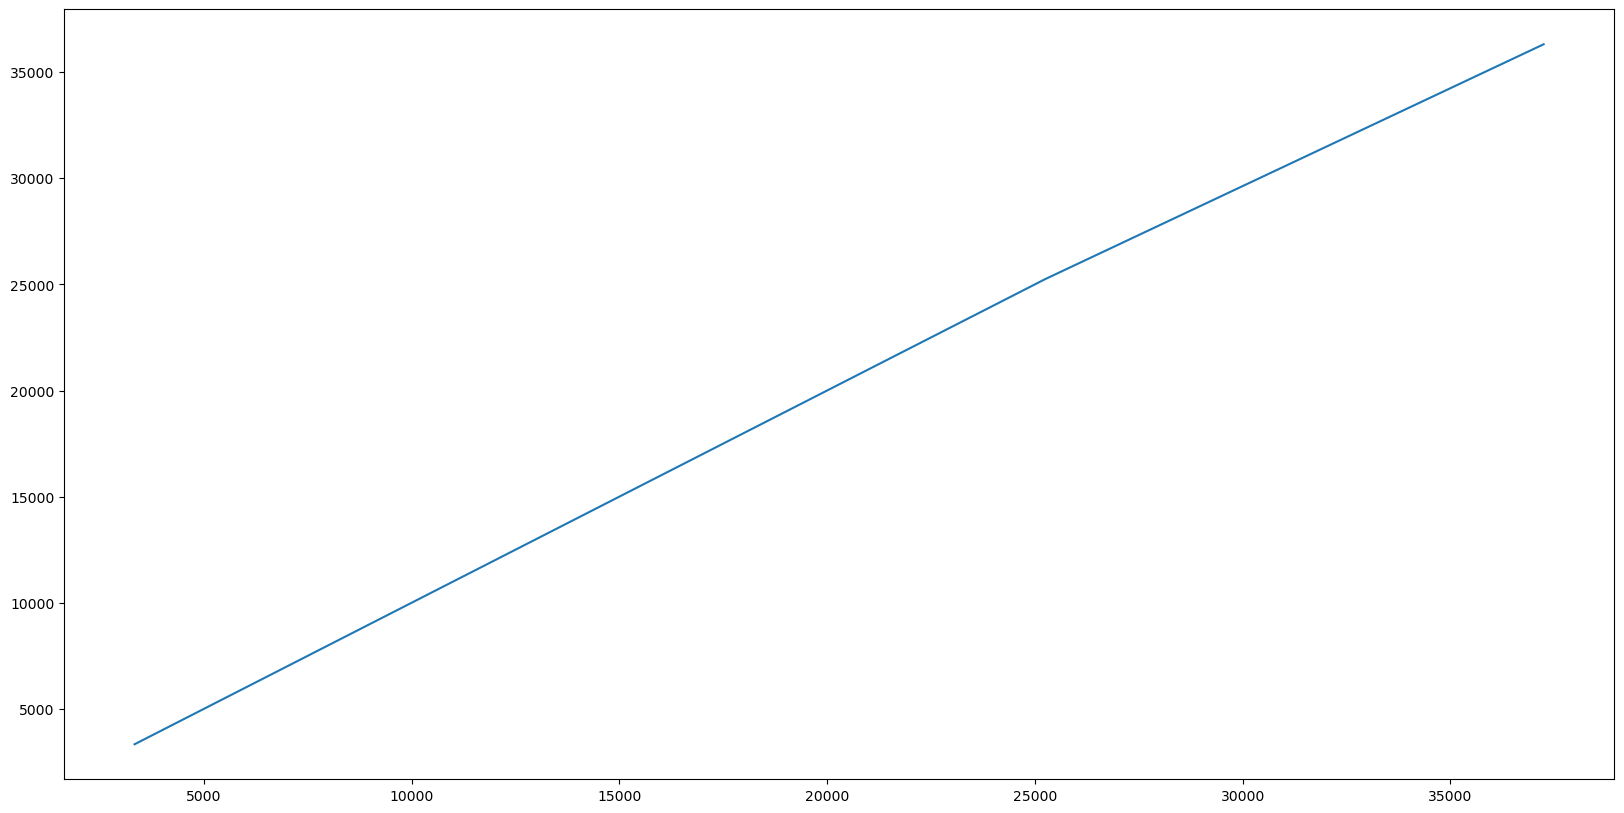

In [9]:
# y_mean
# これは, 特徴量の作成の仕方から線形になるのは当たり前
g_dat = dat[dat["data"]=="Train"].groupby("attract_mean").agg({"y": "mean"}).reset_index(drop=False)
plt.plot(g_dat["attract_mean"], g_dat["y"])

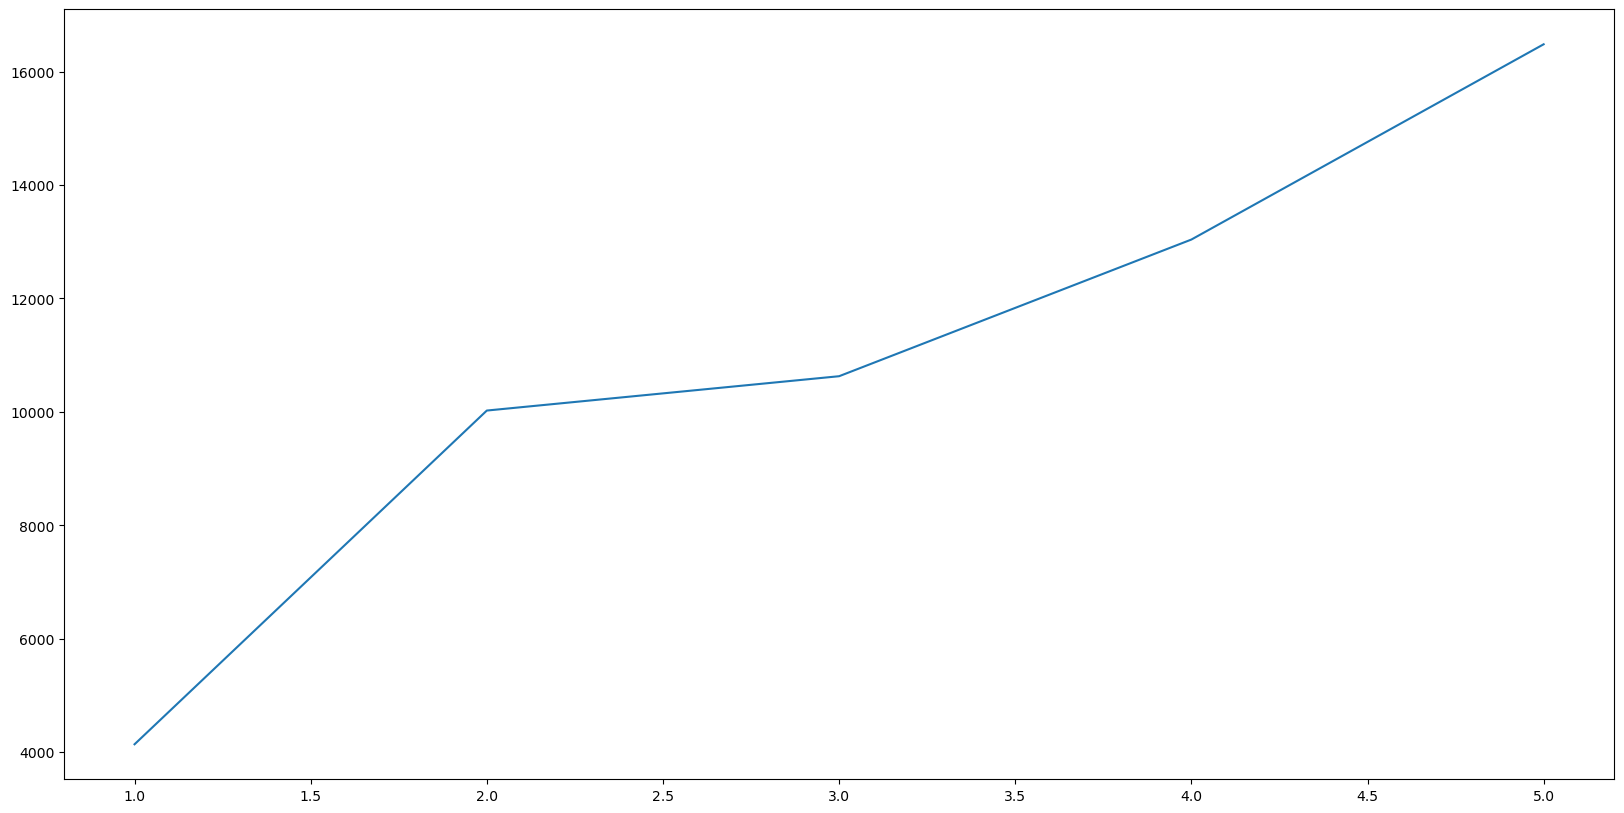

In [10]:
# tv_N
# そのまま線形モデルに入れても良さそう
g_dat = dat[dat["data"]=="Train"].groupby("tv_N").agg({"y": "mean"}).reset_index(drop=False)
plt.plot(g_dat["tv_N"], g_dat["y"])

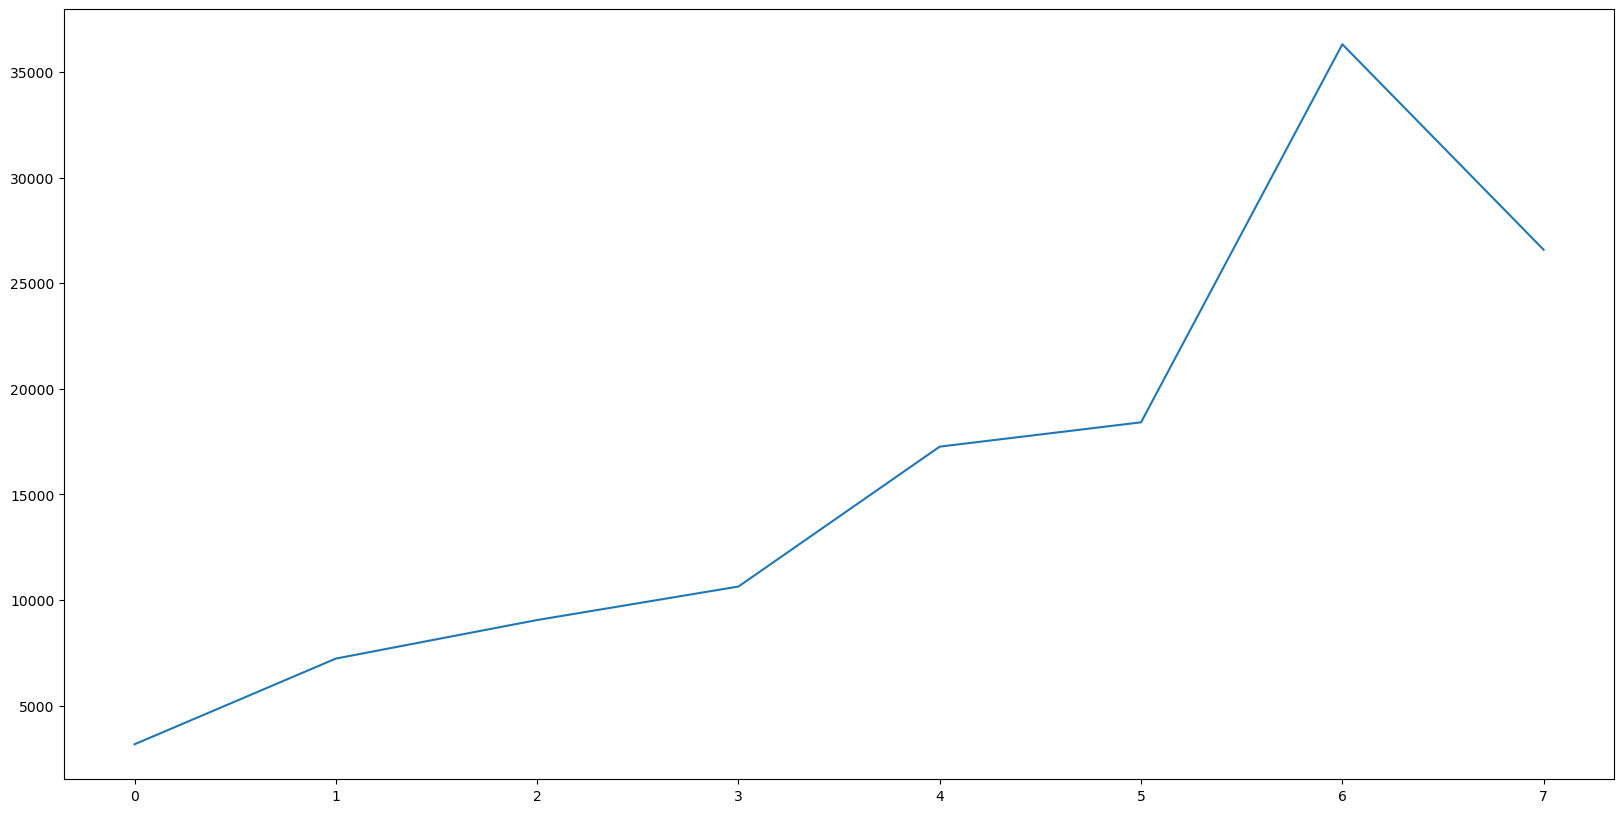

In [11]:
# capa
g_dat = dat[dat["data"]=="Train"].groupby("capa_cate").agg({"y": ["mean", "count"]}).reset_index(drop=False)
g_dat.columns = ["capa_cate", "y", "count"]
plt.plot(g_dat["capa_cate"], g_dat["y"])

In [12]:
# 該当件数も確認
g_dat

,capa_cate,y,count
0,0,3169.857143,7
1,1,7227.487569,724
2,2,9052.624765,533
3,3,10638.663636,110
4,4,17263.032110,218
5,5,18413.559322,59
6,6,36312.700000,40
7,7,26584.700000,30


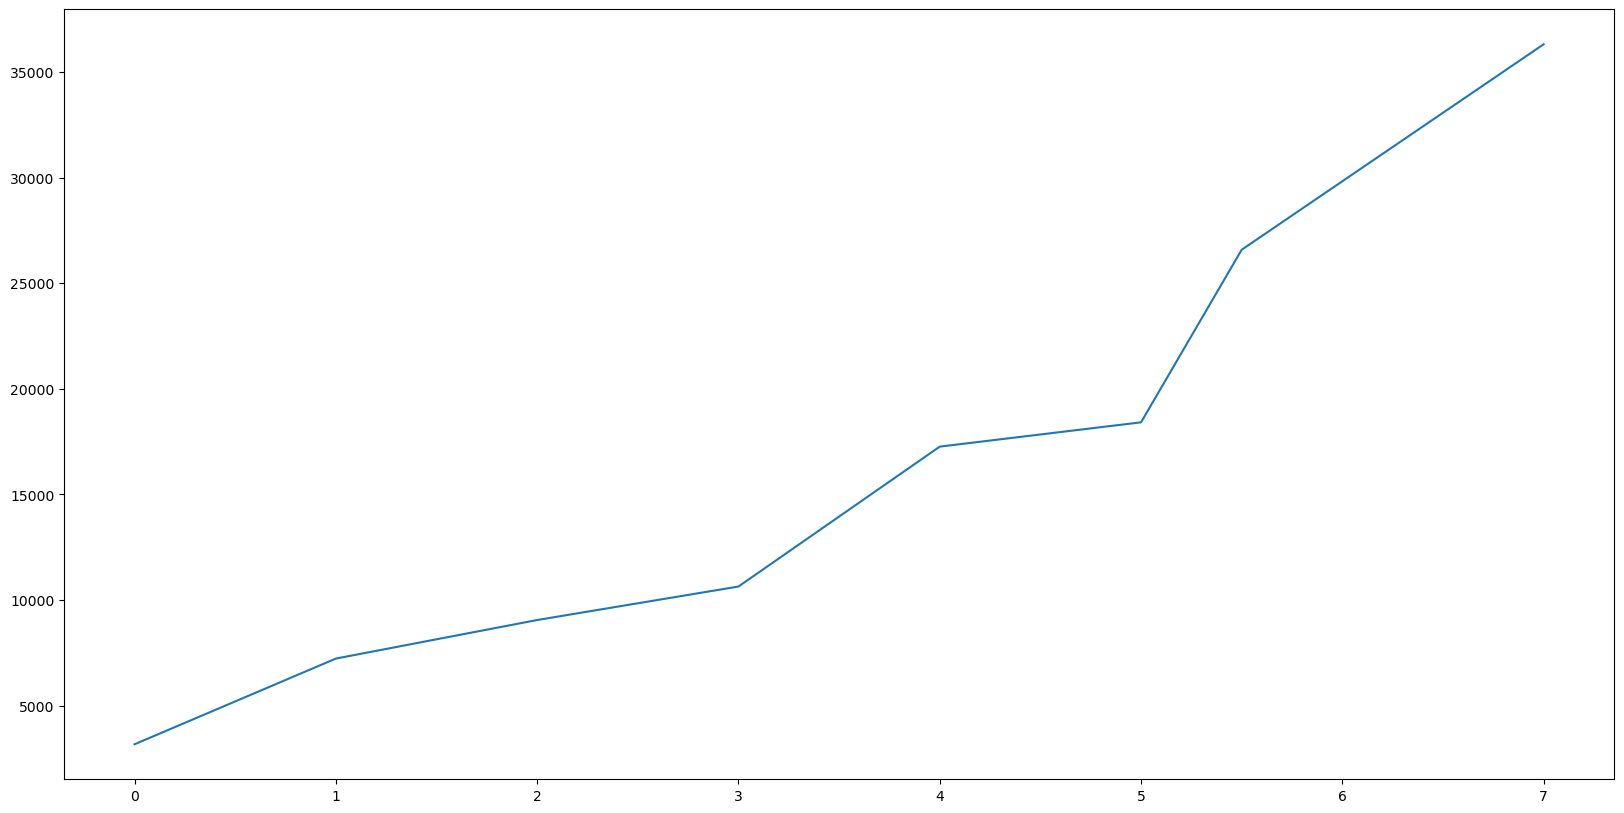

In [13]:
# capaは7万を超えると下がるので, 7 -> 5.5に折り返し, 6 -> 7に移動
dat["capa_cate"] = dat["capa_cate"].apply(lambda x: 5.5 if x == 7 else x)
dat["capa_cate"] = dat["capa_cate"].apply(lambda x: 7 if x == 6 else x)
g_dat = dat[dat["data"]=="Train"].groupby("capa_cate").agg({"y": "mean"}).reset_index(drop=False)
plt.plot(g_dat["capa_cate"], g_dat["y"])

## Check Multicollinearity
　多重共線性の確認は, 相関係数にて行う.

In [14]:
dat[["J1_flg", "December_flg", "attract_mean", "tv_N", "tv_NHK_flg", "capa_cate"]].corr(method="spearman")

,J1_flg,December_flg,attract_mean,tv_N,tv_NHK_flg,capa_cate
J1_flg,1.000000,0.133775,0.790255,0.102055,0.209452,0.303099
December_flg,0.133775,1.000000,0.108735,0.075221,0.100478,0.071129
attract_mean,0.790255,0.108735,1.000000,0.077389,0.181134,0.515376
tv_N,0.102055,0.075221,0.077389,1.000000,0.486005,0.055892
tv_NHK_flg,0.209452,0.100478,0.181134,0.486005,1.000000,0.148869
capa_cate,0.303099,0.071129,0.515376,0.055892,0.148869,1.000000


　J1_flgとattract_meanは相関が高かったので, 情報の少ない方のJ1_flgを外す. -> 外さない方が若干スコアが良かった.

## Make Model
 今回は学習データは観客動員数0の試合を除く.

In [15]:
# Train
train = dat[(dat["data"]=="Train") & (dat["y"] > 0)].copy()
train_x = train[["December_flg", "attract_mean", "tv_N", "tv_NHK_flg", "capa_cate", "J1_flg"]].copy()
train_y = train[["y"]].copy()

# Test
test = dat[dat["data"]=="Test"].copy()
test_x = test[["December_flg", "attract_mean", "tv_N", "tv_NHK_flg", "capa_cate", "J1_flg"]].copy()

In [16]:
# Learning
model = linear_model.LinearRegression()
model.fit(train_x, train_y)

LinearRegression()

In [17]:
model.coef_

array([[ 4.66288698e+03,  7.55713707e-01, -1.10866687e+02,
         1.50709195e+03,  1.01343958e+03,  1.65278548e+03]])

## Predict

In [18]:
pred = model.predict(test_x)

<AxesSubplot:ylabel='Count'>

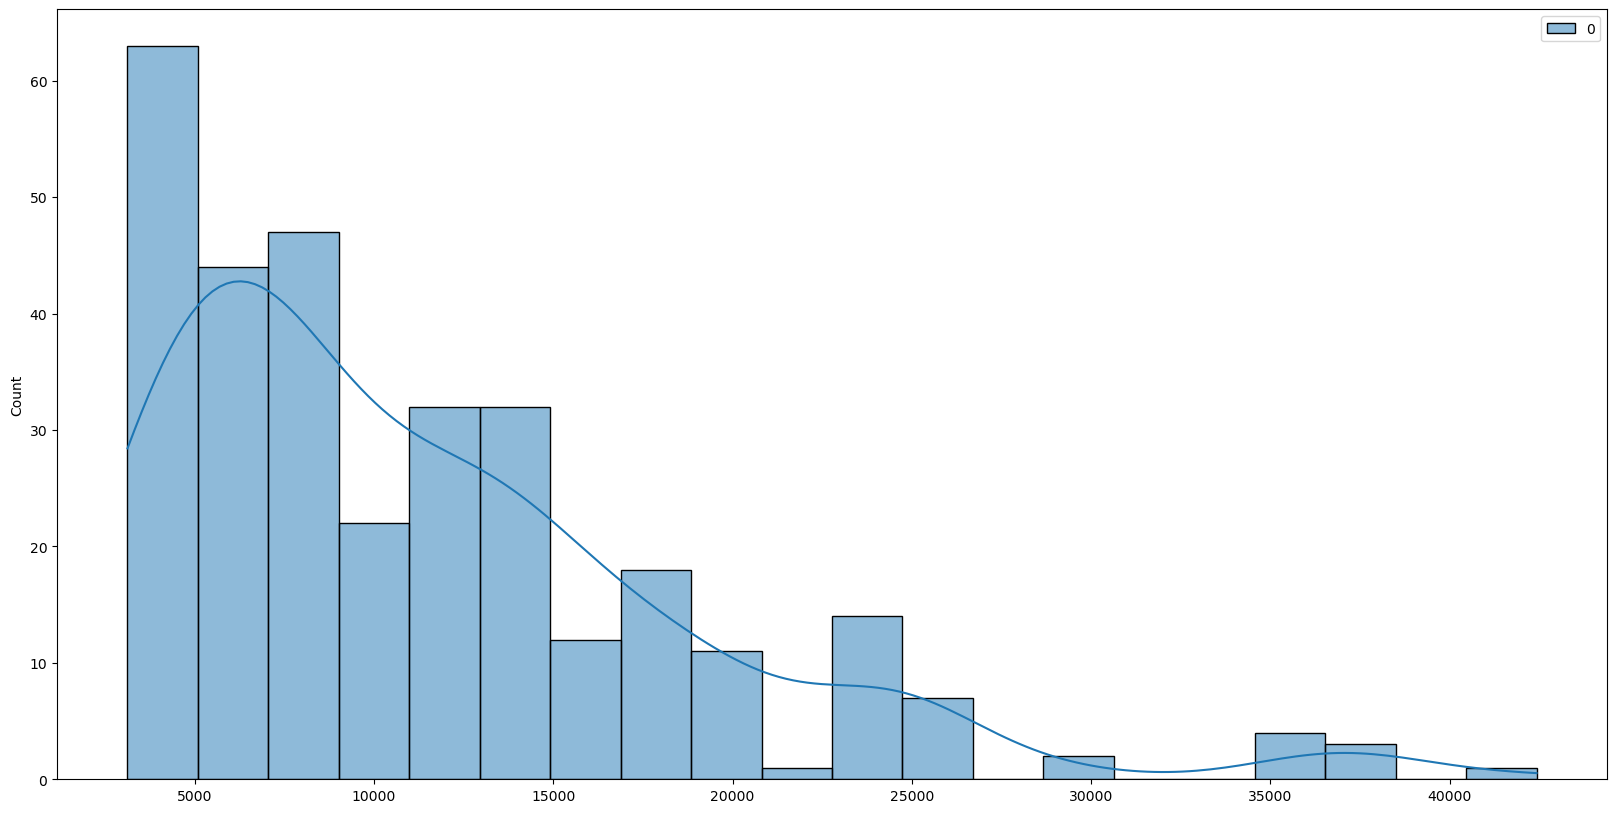

In [19]:
# Check Predict
sns.histplot(pred, kde = True, bins = 20) 

## Predicted Value Correction
　予測値を学習データの最小値とcapa最大値に合わせる.

In [20]:
y_min = train_y.min()
y_min

y    1104.0
dtype: float64

In [21]:
def correction_fun_1(row):
    return max(row["pred"], 1104)

def correction_fun_2(row):
    return min(row["pred"], row["capa"])

pred_correction = test[["capa"]].copy()
pred_correction["pred"] = pred
pred_correction["pred"] = pred_correction.apply(correction_fun_1, axis=1)
pred_correction["pred"] = pred_correction.apply(correction_fun_2, axis=1)

<AxesSubplot:xlabel='pred', ylabel='Count'>

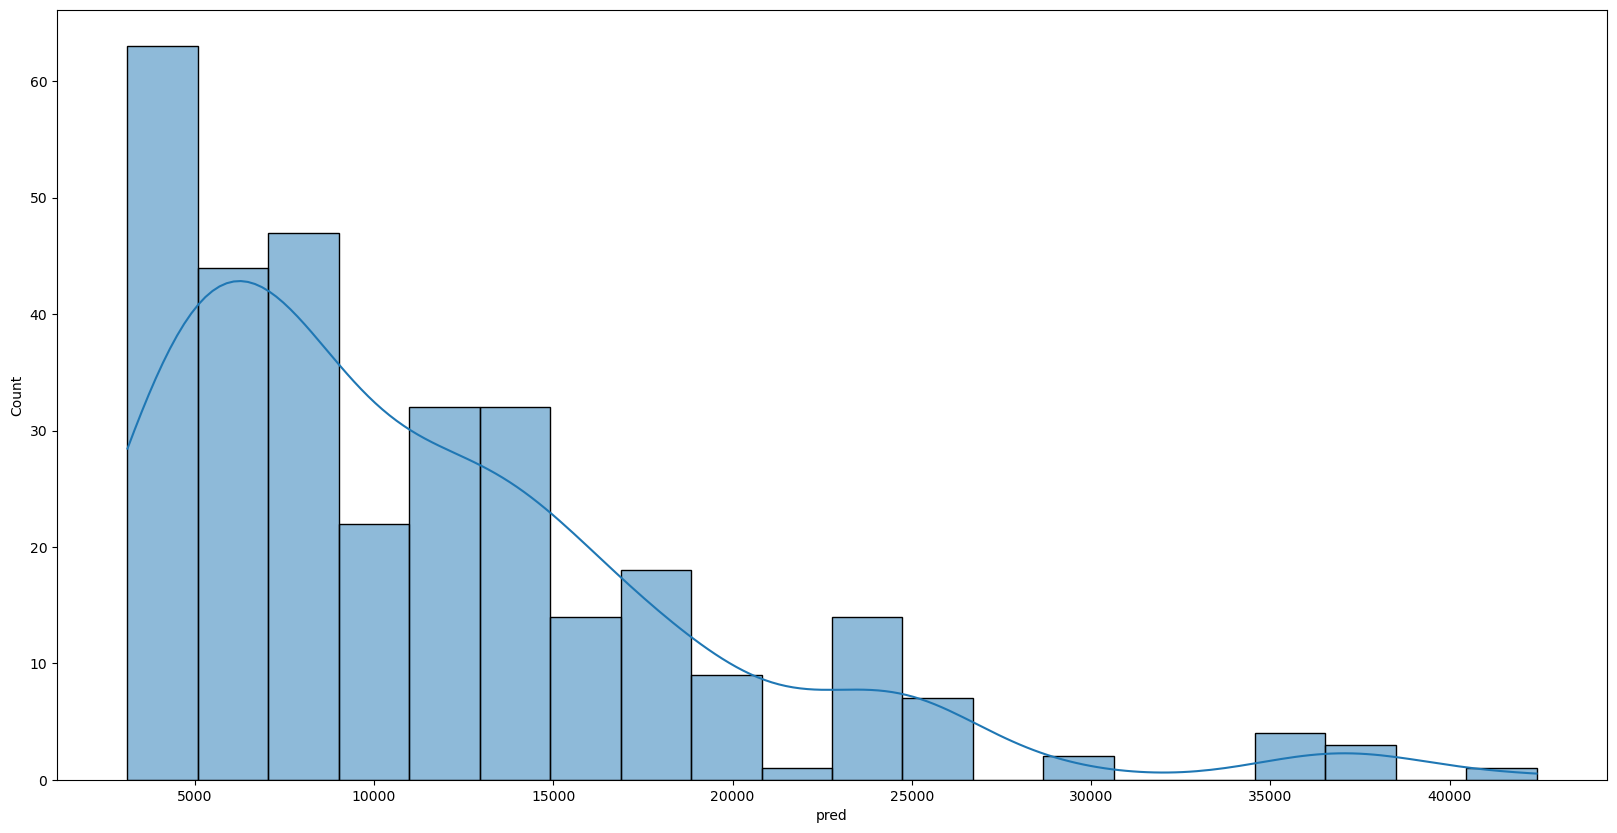

In [22]:
# Check Predict
sns.histplot(pred_correction["pred"], kde = True, bins = 20) 

## Output

In [23]:
submit = test[["id"]].copy()
submit["pred"] = pred_correction["pred"]

In [24]:
submit.to_csv("../submit/submit_linear_sample.csv",  sep=",", index=False, header=False)